## 1. Load the packages

In [1]:
# Data processing packages
import numpy as np
import pandas as pd
from collections import Counter

# Machine learning packages
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import SequentialFeatureSelector, RFE
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import torch


# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

# Others
import time

## 2. Read the data

In [2]:
X1 = torch.load('X1_ready')
Y1 = pd.read_csv("Y1.csv", header=None, names=['revenue ']).values.ravel()
X2 = torch.load('X2_ready')

## 4. Feature Selection

### 4.0 Give the column names to the dataset

In [3]:
def renamingDataset(X):
    new_X = X.copy()
    new_df = pd.DataFrame(new_X)
    num_col_names = ['ratings', 'n_votes', 'production_year', 'runtime', 'release_year']
    cat_col_names = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Others',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western', 'studio_freq', 'is_adult']
    img_emb_names = []
    for i in range(2048):
        img_emb_names.append("img_emb_" + str(i))

    text_emb_names = []
    for i in range(768):
        text_emb_names.append("text_emb_" + str(i))

    all_col_names = num_col_names + cat_col_names + img_emb_names + text_emb_names

    new_df.columns = all_col_names

    return new_df

In [4]:
renamed_df_ready = renamingDataset(X1)

In [5]:
def divideDataset(df):
    new_df = df.copy()

    non_emb_df = new_df.iloc[:, :34]
    img_emb_df = new_df.iloc[:, 34:2082]
    text_emb_df = new_df.iloc[:, 2082:]

    return non_emb_df, img_emb_df, text_emb_df # pd.dataframe type

In [6]:
non_emb_df, img_emb_df, text_emb_df = divideDataset(renamed_df_ready)
non_emb_df

,ratings,n_votes,production_year,runtime,release_year,Action,Adventure,Animation,Biography,Comedy,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,studio_freq,is_adult
0,0.606742,0.809200,1.111354,0.398460,0.933839,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001695,0.0
1,0.764045,-0.271776,-0.073389,0.079814,1.366959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000565,0.0
2,0.539326,-0.256258,-1.596629,1.099479,-2.531122,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.025141,0.0
3,0.617978,-0.215474,-0.242638,0.398460,-0.798642,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.016949,0.0
4,0.337079,-0.265518,-1.258132,0.494053,-2.098002,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.025141,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,0.584270,-0.260586,0.011235,0.047950,-0.257241,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002825,0.0
3536,0.775281,-0.246429,-3.035245,-2.150702,1.691799,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001130,0.0
3537,0.730337,-0.271509,0.349733,-1.545276,-0.148961,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005650,0.0
3538,0.719101,0.046586,0.772856,0.175408,0.500719,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026836,0.0


### 4.1 DR on Embeddings

In [7]:
scaler_emb = MinMaxScaler()
emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))
pca_emb = PCA(n_components=0.9)
pca_emb.fit(emb_df_scaled)

def DRembeddings(img_emb_df, text_emb_df, n_components=0.95):

    # scale the data to the range between 0 and 1 before using PCA
    # scaler_emb = MinMaxScaler()
    # img_emb_df_scaled = scaler_emb.fit_transform(img_emb_df)
    # text_emb_df_scaled = scaler_emb.fit_transform(text_emb_df)
    emb_df_scaled = scaler_emb.fit_transform(pd.concat([img_emb_df, text_emb_df], axis=1))

    # pca_emb = PCA(n_components=n_components)
    # df_reduced_emb = pd.DataFrame(pca_emb.fit_transform(emb_df_scaled))
    df_reduced_emb = pd.DataFrame(pca_emb.transform(emb_df_scaled))

    emb_col_names = []
    for i in range(df_reduced_emb.shape[1]):
        emb_col_names.append("emb_" + str(i))

    df_reduced_emb.columns = emb_col_names

    return df_reduced_emb

In [8]:
df_reduced_emb = DRembeddings(img_emb_df, text_emb_df, n_components=0.9)
df_reduced_emb

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198
0,1.054328,-2.153237,-0.802997,-0.248707,1.349493,-0.057840,1.314132,-0.675291,1.171299,0.436517,...,-0.020153,-0.015117,0.237029,-0.028050,-0.023873,0.079219,-0.031364,-0.071154,-0.091889,-0.235259
1,2.129040,-1.483597,0.043256,0.420362,0.764355,-0.197161,-2.482356,0.903683,-1.484753,-0.512926,...,-0.194736,0.081447,0.099483,-0.115929,0.107830,0.129517,-0.144803,-0.000834,-0.156755,0.159004
2,-0.875198,1.225310,-0.543729,-1.675668,-0.747023,-0.841552,0.549715,-1.524902,-0.489789,0.147765,...,0.092746,0.026760,0.241836,0.224205,0.007772,0.136998,0.067925,-0.050262,0.116298,0.057964
3,-2.737351,-0.962277,-0.147203,0.202019,0.383081,0.646871,1.802819,0.555741,1.016410,0.509889,...,0.222160,-0.061716,0.269019,-0.029332,0.159303,0.049171,0.240762,-0.297771,-0.147129,0.116596
4,-0.188856,-1.475641,1.705273,0.440138,0.412238,-1.173195,-0.601143,-0.155727,-0.484766,-0.416415,...,-0.053639,-0.288431,0.096173,-0.151598,0.179133,0.025855,0.221040,0.155626,-0.151701,-0.016146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,2.200888,-1.601251,-1.428959,-1.419945,-0.136471,-0.784107,0.130939,-0.890358,0.586813,-0.254475,...,0.090543,-0.110694,0.100748,0.411141,-0.191849,0.070196,-0.251843,0.062231,0.173676,-0.353208
3536,2.292233,0.514620,-2.268296,1.002200,-0.883624,-0.801217,-0.707837,0.342407,-0.305779,-0.881682,...,-0.031045,0.055816,0.341487,-0.143810,0.275008,0.035487,-0.250839,-0.502362,-0.521410,0.010129
3537,-0.875170,0.782112,-1.783827,-1.313507,0.580249,-0.994133,-0.276110,-0.226078,0.496469,0.417320,...,-0.156029,0.231721,-0.045153,0.440696,-0.110274,0.025682,-0.034410,-0.120474,0.086602,-0.152570
3538,-2.001723,-1.145958,1.331780,-1.073421,0.935715,-1.775468,-0.476440,1.169051,2.360350,0.496899,...,0.156725,-0.109072,0.018352,-0.131649,-0.065725,-0.041340,-0.030564,-0.380415,0.054779,-0.108390


### 4.2 Feature Selection

In [9]:
# np.random.seed(42)
# rfr = RandomForestRegressor(n_jobs=-1)
# sfs_34features = SequentialFeatureSelector(
#     rfr,
#     k_features=34,
#     forward=True,
#     floating=False,
#     verbose=2,
#     scoring='r2',
#     cv=10,
# ).fit(non_emb_df, np.log(1 + Y1))

In [24]:
# torch.save(sfs_34features, "../models/foward_feature_selection_34features")

In [10]:
sfs_34 = torch.load("../models/foward_feature_selection_20features")

In [11]:
pd.DataFrame.from_dict(sfs_34.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(32,)","[0.517815313938865, 0.5474465442293487, 0.5177...",0.504108,"(studio_freq,)",0.028846,0.038839,0.012946
2,"(1, 32)","[0.6491622718105017, 0.6171114357033527, 0.632...",0.59785,"(n_votes, studio_freq)",0.03361,0.045252,0.015084
3,"(1, 4, 32)","[0.7360864128002844, 0.7198908514784774, 0.746...",0.697545,"(n_votes, release_year, studio_freq)",0.039453,0.05312,0.017707
4,"(1, 3, 4, 32)","[0.7657098206541477, 0.7410537328090163, 0.751...",0.716208,"(n_votes, runtime, release_year, studio_freq)",0.035622,0.047962,0.015987
5,"(0, 1, 3, 4, 32)","[0.7668178531303946, 0.7357804756292788, 0.753...",0.723207,"(ratings, n_votes, runtime, release_year, stud...",0.035294,0.04752,0.01584
6,"(0, 1, 3, 4, 5, 32)","[0.7776944910287957, 0.7386240426950382, 0.759...",0.731262,"(ratings, n_votes, runtime, release_year, Acti...",0.031573,0.042511,0.01417
7,"(0, 1, 3, 4, 5, 29, 32)","[0.7741432623448815, 0.7325063943479908, 0.763...",0.73078,"(ratings, n_votes, runtime, release_year, Acti...",0.030826,0.041504,0.013835
8,"(0, 1, 3, 4, 5, 27, 29, 32)","[0.7723286138655876, 0.7364592379474155, 0.764...",0.732315,"(ratings, n_votes, runtime, release_year, Acti...",0.03111,0.041887,0.013962
9,"(0, 1, 3, 4, 5, 12, 27, 29, 32)","[0.7823437956204866, 0.7394022850186523, 0.767...",0.733878,"(ratings, n_votes, runtime, release_year, Acti...",0.03005,0.040459,0.013486
10,"(0, 1, 3, 4, 5, 12, 27, 29, 31, 32)","[0.7761595572402359, 0.7427339332727853, 0.764...",0.734684,"(ratings, n_votes, runtime, release_year, Acti...",0.02903,0.039087,0.013029


In [12]:
sfs_34.k_feature_idx_

(0, 1, 2, 3, 4, 5, 7, 10, 12, 13, 14, 17, 18, 21, 25, 27, 29, 30, 31, 32)

In [19]:
features_selected = list(sfs_34.k_feature_names_)

In [14]:
sfs_34.k_score_

0.7411025999167815

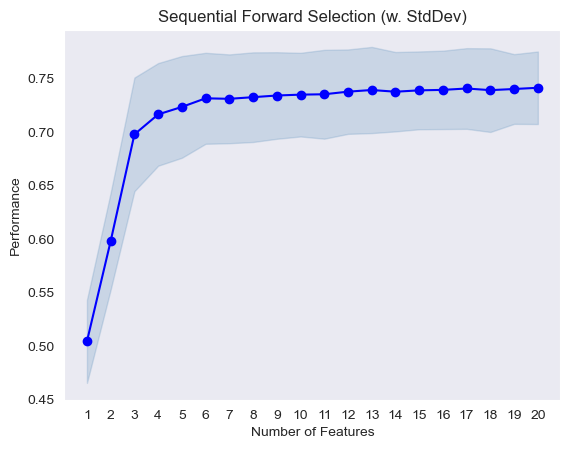

In [15]:
fig1 = plot_sfs(sfs_34.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [21]:
non_emb_df_selected = non_emb_df[features_selected]

### 4.3 Combine non_emb with reduced_emb

In [22]:
def combineNonReducedEmb(non_emb_df_selected, reduced_emb_df):
    DR_df = pd.concat([non_emb_df_selected, reduced_emb_df], axis=1)
    return DR_df

In [23]:
DR_df = combineNonReducedEmb(non_emb_df_selected, df_reduced_emb)

## Pipeline

In [11]:
def FeatureSelection(X, n_components=0.95):
    renamed_df_ready = renamingDataset(X)
    non_emb_df, img_emb_df, text_emb_df = divideDataset(renamed_df_ready)
    reduced_emb_df = DRembeddings(img_emb_df, text_emb_df, n_components=n_components)
    DR_df = combineNonReducedEmb(non_emb_df, reduced_emb_df)

    return DR_df

In [12]:
feature_selection_transformer = FunctionTransformer(FeatureSelection)

In [13]:
p2 = Pipeline([
    ('FeatureSelection', feature_selection_transformer),
    # ('model', Lasso())
])

In [14]:
p2.fit_transform(X1)

,ratings,n_votes,production_year,runtime,release_year,Action,Adventure,Animation,Biography,Comedy,...,emb_189,emb_190,emb_191,emb_192,emb_193,emb_194,emb_195,emb_196,emb_197,emb_198
0,0.606742,0.809200,1.111354,0.398460,0.933839,0.0,1.0,0.0,0.0,1.0,...,-0.020153,-0.015117,0.237029,-0.028050,-0.023873,0.079219,-0.031364,-0.071154,-0.091889,-0.235259
1,0.764045,-0.271776,-0.073389,0.079814,1.366959,1.0,0.0,0.0,0.0,0.0,...,-0.194736,0.081447,0.099483,-0.115929,0.107830,0.129517,-0.144803,-0.000834,-0.156755,0.159004
2,0.539326,-0.256258,-1.596629,1.099479,-2.531122,0.0,0.0,0.0,0.0,0.0,...,0.092746,0.026760,0.241836,0.224205,0.007772,0.136998,0.067925,-0.050262,0.116298,0.057964
3,0.617978,-0.215474,-0.242638,0.398460,-0.798642,0.0,0.0,0.0,1.0,0.0,...,0.222160,-0.061716,0.269019,-0.029332,0.159303,0.049171,0.240762,-0.297771,-0.147129,0.116596
4,0.337079,-0.265518,-1.258132,0.494053,-2.098002,0.0,0.0,0.0,0.0,0.0,...,-0.053639,-0.288431,0.096173,-0.151598,0.179133,0.025855,0.221040,0.155626,-0.151701,-0.016146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,0.584270,-0.260586,0.011235,0.047950,-0.257241,0.0,0.0,0.0,0.0,1.0,...,0.090543,-0.110694,0.100748,0.411141,-0.191849,0.070196,-0.251843,0.062231,0.173676,-0.353208
3536,0.775281,-0.246429,-3.035245,-2.150702,1.691799,0.0,0.0,0.0,0.0,0.0,...,-0.031045,0.055816,0.341487,-0.143810,0.275008,0.035487,-0.250839,-0.502362,-0.521410,0.010129
3537,0.730337,-0.271509,0.349733,-1.545276,-0.148961,0.0,0.0,0.0,0.0,0.0,...,-0.156029,0.231721,-0.045153,0.440696,-0.110274,0.025682,-0.034410,-0.120474,0.086602,-0.152570
3538,0.719101,0.046586,0.772856,0.175408,0.500719,0.0,0.0,0.0,0.0,0.0,...,0.156725,-0.109072,0.018352,-0.131649,-0.065725,-0.041340,-0.030564,-0.380415,0.054779,-0.108390


## 5. Model

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

### 5.1 Linear Regression

In [28]:
LR_model = LinearRegression()
scores = cross_val_score(LR_model, X1, Y1, cv=10, verbose=2)


# kf = KFold(n_splits=5, random_state=1, shuffle=True)
# train_scores = []
# valid_scores = []
#
# for i, (train_index, valid_index) in enumerate(kf.split(X1)):
#     X_train = X1[train_index,:]
#     y_train = Y1[train_index]
#     X_valid = X1[valid_index,:]
#     y_valid = Y1[valid_index]
#
#     model.fit(X_train, np.log(1 + y_train))
#     train_score = model.score(X_train, np.log(1 + y_train))
#     valid_score = model.score(X_valid, np.log(1 + y_valid))
#     train_scores.append(round(train_score, 6))
#     valid_scores.append(round(valid_score, 6))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   7.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] END .................................................... total time=   5.7s
[CV] END .................................................... total time=   6.6s
[CV] END .................................................... total time=   5.3s
[CV] END .................................................... total time=   5.5s
[CV] END .................................................... total time=   5.4s
[CV] END .................................................... total time=   5.4s
[CV] END .................................................... total time=   5.7s
[CV] END .................................................... total time=   8.6s
[CV] END .................................................... total time=   9.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


array([-190.62080506, -156.38776382, -297.10558592, -300.41254007,
       -523.16780132, -453.39744215, -217.57674454,  -55.45779738,
       -294.12843735, -153.87180725])

### 5.2 MLP

In [90]:
MLP_model = MLPRegressor(hidden_layer_sizes=(1000, 500, 100, 50),
                         max_iter = 500, activation = 'relu',
                         learning_rate='constant', learning_rate_init=0.001, random_state=42)

# scores = cross_val_score(MLP_model, X1, Y1, cv=5, verbose=2)
# # MLP_model.fit(X1, Y1)

In [91]:
MLP_model.fit(X_train, np.log(1 + y_train))

MLPRegressor(hidden_layer_sizes=(1000, 500, 100, 50), max_iter=500,
             random_state=42)

In [92]:
MLP_model.score(X_val, np.log(1 + y_val))

0.4173746542215616

In [93]:
y_pre = MLP_model.predict(X_val)

In [94]:
np.vstack([y_val, np.exp(y_pre)]).T

array([[1.41136217e+07, 1.63255000e+07],
       [3.98230516e+08, 5.65297205e+07],
       [1.04222857e+04, 2.33458623e+03],
       ...,
       [1.40858624e+06, 3.33221359e+05],
       [3.46415615e+07, 2.03076076e+07],
       [1.25996951e+04, 2.15869407e+04]])

### 5.3 KNN

In [107]:
KNN_model = KNeighborsRegressor(n_neighbors = 150)
KNN_model.fit(X_train, np.log(1 + y_train))
KNN_model.score(X_val, np.log(1 + y_val))

0.10686212585720234

In [108]:
y_pre = MLP_model.predict(X_val)
np.vstack([y_val, np.exp(y_pre)]).T

array([[1.41136217e+07, 1.63255000e+07],
       [3.98230516e+08, 5.65297205e+07],
       [1.04222857e+04, 2.33458623e+03],
       ...,
       [1.40858624e+06, 3.33221359e+05],
       [3.46415615e+07, 2.03076076e+07],
       [1.25996951e+04, 2.15869407e+04]])